In [10]:
import os

os.makedirs("scripts", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/splits/tightcrop", exist_ok=True)
os.makedirs("results", exist_ok=True)


In [2]:
%%writefile scripts/data.py
# scripts/data.py
#
# Dataset loader for CSV splits produced by dataset_prep.py:
#   data/splits/tightcrop/{train,val,test}.csv
# CSV columns:
#   - image_path
#   - class  (glioma/meningioma/pituitary/notumor)

import os
from pathlib import Path
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T


class AddGaussianNoise:
    def __init__(self, std=0.02, p=0.5):
        self.std = std
        self.p = p

    def __call__(self, x):
        if torch.rand(1).item() > self.p:
            return x
        noise = torch.randn_like(x) * self.std
        x = x + noise
        return torch.clamp(x, 0.0, 1.0)


def _resolve_path(p, project_root):
    # Your CSV may contain absolute paths from a different machine.
    # This resolver makes the project portable for Colab/Kaggle.
    if os.path.exists(p):
        return p

    p2 = str(p).replace("\\", "/")
    key = "/data/processed/"
    idx = p2.find(key)
    if idx != -1:
        rel = p2[idx + 1:]  # remove leading '/'
        cand = str(Path(project_root) / rel)
        if os.path.exists(cand):
            return cand

    # fallback: try relative to project_root directly
    cand2 = str(Path(project_root) / p2)
    if os.path.exists(cand2):
        return cand2

    return p  # let it fail loudly in __getitem__ for debugging


def build_transforms(train, mean, std):
    ops = []
    if train:
        ops.extend([
            T.RandomRotation(degrees=15),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        ])

    ops.extend([T.ToTensor()])

    if train:
        ops.append(AddGaussianNoise(std=0.02, p=0.5))

    ops.append(T.Normalize(mean=mean, std=std))
    return T.Compose(ops)


class BrainMRICSV(Dataset):
    def __init__(self, csv_path, class_names, transform, project_root):
        self.df = pd.read_csv(csv_path)
        self.class_names = class_names
        self.class_to_idx = {c: i for i, c in enumerate(class_names)}
        self.transform = transform
        self.project_root = project_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = _resolve_path(row["image_path"], self.project_root)
        y_str = row["class"]
        y = self.class_to_idx[y_str]

        img = Image.open(img_path).convert("RGB")
        x = self.transform(img)
        return x, y, img_path



Writing scripts/data.py


In [3]:
%%writefile scripts/dataset_prep.py
# dataset_prep.py
# I started working on dataset preparation from 12th november 2025

# -------------------------------------------------------------------
# dataset preparation pipeline (what I already did)
#
# In this script I had:
#   - walked the original Kaggle brain tumour MRI folders and recorded
#     every file path together with its class and Kaggle split
#     (Training / Testing),
#   - computed SHA1 hashes to detect and remove exact byte-for-byte
#     duplicate files, while also saving a detailed duplicate summary,
#   - audited every deduplicated raw image for geometry and intensity:
#       – width, height, aspect ratio,
#       – mean / std / min / max grayscale intensity,
#       – conservative flags for too dark, too bright, low contrast,
#         and a combined "suspect" quality flag,
#   - produced CSV summaries for raw resolutions and quality flags so
#     that I could describe the original dataset objectively in the
#     report,
#   - created a *leakage-safe* split aligned to Kaggle's intended protocol:
#       - Kaggle Training -> stratified Train/Val
#       - Kaggle Testing  -> held-out Test (never used for training)
#   - defined a tight brain-cropping function that removed black
#     background based on an intensity threshold plus a small margin,
#   - applied this crop to every image in the split, resized to
#     224x224 (matching ImageNet / ResNet50V2 / RViT defaults),
#     converted to RGB, and saved them into a clean
#     data/processed/tightcrop/{split}/{class}/ structure,
#   - saved train/val/test CSVs that point to these cropped 224×224
#     images (for model training and evaluation),
#   - saved an overall split summary CSV with per-class counts per
#     split, which I later used to generate figures in dataset_plots.py.
#
# This file therefore gave me a single, reproducible, auditable
# pipeline from raw Kaggle folders -> cleaned, cropped 224x224 dataset
# and analysis artefacts for the project's methodology section.
# -------------------------------------------------------------------

"""
Dataset preparation script for HybridResNet50V2–RViT brain tumour classification.

This file builds one reproducible pipeline that:

  - walks the raw Kaggle folders and records exactly what is there,
  - removes byte-for-byte duplicate files using SHA1 with a leakage-safe policy
    (prefer keeping Kaggle Testing copies when duplicates exist across splits),
  - audits raw images for geometry and intensity problems
    (so we can describe “suspect” images with evidence),
  - creates a Kaggle-aligned evaluation protocol:
      * Kaggle Training -> stratified Train/Val split (default 80/20),
      * Kaggle Testing  -> held-out Test set,
  - and finally writes *cropped* 224×224 RGB images and CSVs for model training.

Important design decisions:

  - All model training uses only the cropped 224×224 images.
  - Cropping is done first (tight crop around brain region), then resized to 224×224.
  - The audit (intensity, duplicates) is always done on the raw
    uncropped images so we can describe the original dataset properly.
  - Exact duplicates are removed BEFORE splitting, and duplicates that cross
    Training/Testing are resolved by keeping the Testing copy to avoid leakage.
"""

import os
from pathlib import Path
import hashlib
import math

import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm


# -------------------------------------------------------------------
# CONFIGURATION SECTION
# -------------------------------------------------------------------

from pathlib import Path

# Kaggle paths
RAW_DATA_DIR = Path("/kaggle/input/btc-dataset")
PROJECT_ROOT = Path("/kaggle/working")

# 🔑 FIX: point to actual dataset root
RAW_ROOT = RAW_DATA_DIR / "kaggle_brain_mri_scan_dataset"

PROCESSED_BASE = PROJECT_ROOT / "data" / "processed"
SPLITS_BASE = PROJECT_ROOT / "data" / "splits"
RESULTS_DIR = PROJECT_ROOT / "results"

VARIANT = "tightcrop"
PROCESSED_ROOT = PROCESSED_BASE / VARIANT
SPLITS_ROOT = SPLITS_BASE / VARIANT

SUMMARY_PATH                 = RESULTS_DIR / "dataset_summary.csv"
RAW_STATS_PATH               = RESULTS_DIR / "raw_image_stats.csv"
RAW_RESOLUTION_SUMMARY_PATH  = RESULTS_DIR / "raw_resolution_summary.csv"
RAW_QUALITY_SUMMARY_PATH     = RESULTS_DIR / "raw_quality_flags_summary.csv"
RAW_CLASS_COUNTS_PATH        = RESULTS_DIR / "raw_class_counts_by_source.csv"
DUPLICATES_PATH              = RESULTS_DIR / "duplicate_files.csv"
DUPLICATE_SUMMARY_PATH       = RESULTS_DIR / "duplicate_summary.csv"


IMG_SIZE = (224, 224)
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]
RANDOM_STATE = 42

# Kaggle-aligned split:
# - Training -> Train/Val
# - Testing  -> Test (held-out)
VAL_FRACTION_OF_TRAINING = 0.20   # 80/20 split inside Kaggle Training

# Dedup policy:
# If an exact duplicate exists in BOTH Training and Testing, keep Testing copy.
PREFER_TESTING_ON_CROSS_SPLIT_DUPLICATES = True

BACKGROUND_INTENSITY_THRESHOLD = 5
CROP_MARGIN = 10

# Only process real image files (prevents .DS_Store, Thumbs.db, etc.)
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


def _get_resample():
    """
    Pillow version compatibility: Image.Resampling exists in newer versions.
    We pick LANCZOS for best downsampling quality.
    """
    try:
        return Image.Resampling.LANCZOS
    except AttributeError:
        return Image.LANCZOS


RESAMPLE = _get_resample()


# -------------------------------------------------------------------
# COLLECTING RAW IMAGE PATHS
# -------------------------------------------------------------------

def collect_images() -> pd.DataFrame:
    """
    Walk through the raw Kaggle folders and build a DataFrame.

    For each file record:
      - orig_path    : full path on disk
      - class        : glioma / meningioma / pituitary / notumor
      - source_split : "training" or "testing" (Kaggle's folder)
    """
    records = []

    for split in ["Training", "Testing"]:
        for cls in CLASSES:
            folder = RAW_ROOT / split / cls
            if not folder.exists():
                continue

            for p in folder.iterdir():
                if not p.is_file():
                    continue

                # Skip hidden/system files and non-image extensions
                if p.name.startswith("."):
                    continue
                if p.suffix.lower() not in ALLOWED_EXTS:
                    continue

                records.append(
                    {
                        "orig_path": str(p),
                        "class": cls,
                        "source_split": split.lower(),  # "training" / "testing"
                    }
                )

    df = pd.DataFrame(records)
    print(f"Total images found (before deduplication): {len(df)}")
    return df


def save_raw_class_counts(df: pd.DataFrame):
    """
    Summarise how many images there are per class in Kaggle's
    original Training vs Testing folders.

    Output: results/raw_class_counts_by_source.csv
    """
    RAW_CLASS_COUNTS_PATH.parent.mkdir(parents=True, exist_ok=True)

    if df.empty:
        print("No images found; raw class counts not saved.")
        return

    counts = (
        df.groupby(["source_split", "class"])
        .size()
        .reset_index(name="count")
        .sort_values(["source_split", "class"])
    )

    counts.to_csv(RAW_CLASS_COUNTS_PATH, index=False)
    print(f"Saved raw class counts (by Kaggle split) to {RAW_CLASS_COUNTS_PATH}")
    print(counts)


# -------------------------------------------------------------------
# EXACT DUPLICATE REMOVAL (SHA1) - LEAKAGE SAFE
# -------------------------------------------------------------------

def sha1_of_file(path: str, block_size: int = 65536) -> str:
    """
    Compute SHA1 hash of a file.
    If two files have the same SHA1, they are byte-for-byte identical.
    """
    h = hashlib.sha1()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()

def processed_filename_for(orig_path: str) -> str:
    """
    Build a unique, deterministic filename for the processed image
    to avoid collisions (same src.name in different folders).

    We use SHA1(file_bytes) + original extension.
    """
    p = Path(orig_path)
    return f"{sha1_of_file(str(p))}{p.suffix.lower()}"


def drop_duplicates_leakage_safe(df: pd.DataFrame):
    """
    Remove exact duplicate files based on SHA1, using a leakage-safe policy.

    Key rule:
      - If a duplicate group spans BOTH Kaggle Training and Kaggle Testing,
        we KEEP the Testing copy and DROP the Training copy(s).

    Returns:
      - dedup_df : DataFrame of kept rows only (unique SHA1)
      - dups_df  : DataFrame of all rows that belong to duplicate groups,
                  including which file was kept/dropped
    """
    if df.empty:
        return df.copy(), pd.DataFrame()

    print("Computing SHA1 hashes for duplicate detection...")
    df = df.copy()
    df["sha1"] = df["orig_path"].apply(sha1_of_file)

    before = len(df)

    # Identify duplicate groups (size >= 2)
    dup_mask = df.duplicated(subset="sha1", keep=False)
    dups_df = df[dup_mask].copy()

    if dups_df.empty:
        print("No duplicate files detected based on SHA1 hashes.")
        dedup_df = df.reset_index(drop=True)
        print(f"Unique files after deduplication: {len(dedup_df)}")
        return dedup_df, dups_df

    keep_indices = []

    # For deterministic behaviour, we sort paths inside each group
    for sha1, group in dups_df.groupby("sha1"):
        g = group.sort_values(["source_split", "orig_path"]).copy()

        has_testing = (g["source_split"] == "testing").any()
        has_training = (g["source_split"] == "training").any()

        # Leakage-safe decision:
        if PREFER_TESTING_ON_CROSS_SPLIT_DUPLICATES and has_testing and has_training:
            # Keep ONE testing copy (deterministic: lexicographically smallest testing path)
            keep_row = g[g["source_split"] == "testing"].sort_values("orig_path").iloc[0]
        else:
            # Otherwise keep ONE file deterministically (smallest path)
            keep_row = g.sort_values("orig_path").iloc[0]

        keep_indices.append(int(keep_row.name))

    # Keep all non-duplicates + one representative from each duplicate group
    non_dup_df = df[~dup_mask].copy()
    kept_from_dups_df = df.loc[keep_indices].copy()

    dedup_df = pd.concat([non_dup_df, kept_from_dups_df], axis=0).reset_index(drop=True)

    after = len(dedup_df)
    print(f"Unique files after deduplication: {after}")
    print(f"Removed {before - after} duplicate file entries (if any).")

    # Augment dups_df with keep/drop info for auditing
    dups_df = dups_df.copy()
    dups_df["kept"] = False

    # Mark kept rows inside duplicate groups
    kept_set = set(keep_indices)
    dups_df.loc[dups_df.index.isin(kept_set), "kept"] = True

    # Also include which path was kept in the group (helpful for report/audit)
    kept_path_by_sha1 = (
        dups_df[dups_df["kept"]]
        .set_index("sha1")["orig_path"]
        .to_dict()
    )
    dups_df["kept_path_for_group"] = dups_df["sha1"].map(kept_path_by_sha1)

    return dedup_df, dups_df


def save_duplicate_summary(dups_df: pd.DataFrame):
    """
    Write detailed information about exact duplicates:

      - duplicate_files.csv   : full listing of all duplicate-group members,
                               including which one was kept
      - duplicate_summary.csv : one row per SHA1 group
    """
    DUPLICATES_PATH.parent.mkdir(parents=True, exist_ok=True)

    if dups_df is None or dups_df.empty:
        print("No duplicate files to save.")
        return

    dups_df.to_csv(DUPLICATES_PATH, index=False)
    print(f"Saved full duplicate listing to {DUPLICATES_PATH}")

    rows = []
    for sha1, group in dups_df.groupby("sha1"):
        group = group.copy()

        kept_rows = group[group["kept"]]
        kept_path = kept_rows["orig_path"].iloc[0] if not kept_rows.empty else ""

        # Helpful flags: duplicates crossing splits, or (rare) crossing classes
        crosses_splits = group["source_split"].nunique() > 1
        crosses_classes = group["class"].nunique() > 1

        rows.append(
            {
                "sha1": sha1,
                "n_files": len(group),
                "crosses_splits": bool(crosses_splits),
                "crosses_classes": bool(crosses_classes),
                "classes": ";".join(sorted(group["class"].unique())),
                "source_splits": ";".join(sorted(group["source_split"].unique())),
                "kept_path": kept_path,
                "dropped_paths_example": "; ".join(group[~group["kept"]]["orig_path"].head(5)),
            }
        )

    summary_df = pd.DataFrame(rows).sort_values("n_files", ascending=False)
    summary_df.to_csv(DUPLICATE_SUMMARY_PATH, index=False)
    print(f"Saved duplicate summary to {DUPLICATE_SUMMARY_PATH}")
    print(summary_df.head())


# -------------------------------------------------------------------
# RAW IMAGE ANALYSIS (GEOMETRY and INTENSITY)
# -------------------------------------------------------------------

def analyze_raw_images(df: pd.DataFrame) -> pd.DataFrame:
    """
    Audit each deduplicated raw image before resizing.

    For each image record:
      - width, height, aspect_ratio
      - grayscale intensity stats: mean, std, min, max
      - a 'failed' flag if PIL couldn't read the file
      - conservative quality flags:
          too_dark, too_bright, low_contrast, suspect

    This function does NOT drop images; it only flags them.
    """
    records = []
    print("Analysing raw image geometry and intensity statistics...")

    for row in tqdm(df.to_dict(orient="records"), desc="Analysing raw images"):
        path = row["orig_path"]
        cls = row["class"]
        source_split = row["source_split"]
        sha1 = row.get("sha1", None)

        width = height = None
        aspect_ratio = None
        mean_intensity = std_intensity = None
        min_intensity = max_intensity = None
        failed = False

        try:
            img = Image.open(path)
            img = ImageOps.exif_transpose(img)
            img.load()  # force decode to catch corrupt images

            width, height = img.size
            aspect_ratio = (width / height) if height else np.nan

            gray = img.convert("L")
            arr = np.array(gray, dtype=np.float32)

            mean_intensity = float(arr.mean())
            std_intensity = float(arr.std())
            min_intensity = float(arr.min())
            max_intensity = float(arr.max())

        except Exception as e:
            print(f"Failed to analyse {path}: {e}")
            failed = True

        records.append(
            {
                "orig_path": path,
                "class": cls,
                "source_split": source_split,
                "sha1": sha1,
                "width": width,
                "height": height,
                "aspect_ratio": aspect_ratio,
                "mean_intensity": mean_intensity,
                "std_intensity": std_intensity,
                "min_intensity": min_intensity,
                "max_intensity": max_intensity,
                "failed": failed,
            }
        )

    stats_df = pd.DataFrame(records)
    not_failed = ~stats_df["failed"]

    stats_df["too_dark"] = (
        not_failed
        & (stats_df["mean_intensity"] < 15)
        & (stats_df["max_intensity"] < 60)
    )

    stats_df["too_bright"] = (
        not_failed
        & (stats_df["mean_intensity"] > 240)
        & (stats_df["min_intensity"] > 200)
    )

    stats_df["low_contrast"] = not_failed & (stats_df["std_intensity"] < 5)

    stats_df["suspect"] = (
        stats_df["too_dark"]
        | stats_df["too_bright"]
        | stats_df["low_contrast"]
        | stats_df["failed"]
    )

    return stats_df


def save_raw_analysis(stats_df: pd.DataFrame):
    """
    Save raw-image analysis to:
      - raw_image_stats.csv
      - raw_resolution_summary.csv
      - raw_quality_flags_summary.csv
    """
    RAW_STATS_PATH.parent.mkdir(parents=True, exist_ok=True)

    if stats_df.empty:
        print("No stats to save; stats_df is empty.")
        return

    stats_df.to_csv(RAW_STATS_PATH, index=False)
    print(f"Saved raw image stats to {RAW_STATS_PATH}")

    res_summary = (
        stats_df.groupby(["width", "height"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    res_summary.to_csv(RAW_RESOLUTION_SUMMARY_PATH, index=False)
    print(f"Saved resolution summary to {RAW_RESOLUTION_SUMMARY_PATH}")
    print("Top 5 most common resolutions:")
    print(res_summary.head())

    qual_summary = (
        stats_df.groupby("class")[["too_dark", "too_bright", "low_contrast", "suspect", "failed"]]
        .sum()
        .reset_index()
    )
    qual_summary.to_csv(RAW_QUALITY_SUMMARY_PATH, index=False)
    print(f"Saved quality flags summary to {RAW_QUALITY_SUMMARY_PATH}")
    print(qual_summary)

    total_suspect = int(stats_df["suspect"].sum())
    print(f"Total suspect images (any flag or failed): {total_suspect}")


# -------------------------------------------------------------------
# TIGHT BRAIN CROPPING - KAGGLE-ALIGNED SPLITS - RESIZED IMAGES
# -------------------------------------------------------------------

def tight_crop_to_brain(img: Image.Image) -> Image.Image:
    """
    Crop away black background around the brain using a simple intensity mask.
    If no foreground pixels are found, return the original image.
    """
    gray = img.convert("L")
    arr = np.array(gray, dtype=np.uint8)

    mask = arr > BACKGROUND_INTENSITY_THRESHOLD
    if not mask.any():
        return img

    ys, xs = np.where(mask)

    y_min = max(int(ys.min()) - CROP_MARGIN, 0)
    y_max = min(int(ys.max()) + 1 + CROP_MARGIN, arr.shape[0])

    x_min = max(int(xs.min()) - CROP_MARGIN, 0)
    x_max = min(int(xs.max()) + 1 + CROP_MARGIN, arr.shape[1])

    return img.crop((x_min, y_min, x_max, y_max))


def make_splits_kaggle_aligned(df: pd.DataFrame):
    """
    Create leakage-safe, Kaggle-aligned splits:

      - Train/Val are created ONLY from Kaggle Training images (stratified).
      - Test is the Kaggle Testing folder (held-out, no splitting).

    This is the correct evaluation setup for this Kaggle dataset:
    we do NOT create a new test set from Training because Kaggle already provides one.
    """
    if df.empty:
        raise ValueError("Cannot split an empty dataset.")

    df_train_source = df[df["source_split"] == "training"].copy()
    df_test_source  = df[df["source_split"] == "testing"].copy()

    if df_train_source.empty:
        raise ValueError("No Kaggle Training images found after deduplication.")
    if df_test_source.empty:
        print("WARNING: No Kaggle Testing images found after deduplication. Test set will be empty.")

    X = df_train_source["orig_path"].values
    y = df_train_source["class"].values

    # Stratified train/val split inside Kaggle Training only
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y,
            test_size=VAL_FRACTION_OF_TRAINING,
            stratify=y,
            random_state=RANDOM_STATE,
        )
    except Exception as e:
        # Fallback: non-stratified split (should not happen with this dataset, but keeps script robust)
        print(f"WARNING: Stratified split failed ({e}). Falling back to non-stratified split.")
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y,
            test_size=VAL_FRACTION_OF_TRAINING,
            random_state=RANDOM_STATE,
        )

    def to_df(paths, labels, split_name: str) -> pd.DataFrame:
        return pd.DataFrame(
            {
                "orig_path": [str(Path(p)) for p in paths],
                "class": labels,
                "split": split_name,
            }
        )

    df_train = to_df(X_train, y_train, "train")
    df_val   = to_df(X_val, y_val, "val")

    # Kaggle Testing is held-out test
    df_test = pd.DataFrame(
        {
            "orig_path": df_test_source["orig_path"].astype(str).values,
            "class": df_test_source["class"].values,
            "split": "test",
        }
    )

    print("Split sizes (Kaggle-aligned, after deduplication):")
    print(f"  Train (from Kaggle Training): {len(df_train)}")
    print(f"  Val   (from Kaggle Training): {len(df_val)}")
    print(f"  Test  (Kaggle Testing):       {len(df_test)}")

    return df_train, df_val, df_test


def prepare_processed_dirs():
    """
    Ensure canonical directory structure exists for the cropped variant:

        data/processed/tightcrop/train/{class}/
        data/processed/tightcrop/val/{class}/
        data/processed/tightcrop/test/{class}/
    """
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            out_dir = PROCESSED_ROOT / split / cls
            out_dir.mkdir(parents=True, exist_ok=True)


def resize_and_copy(df_split: pd.DataFrame, split_name: str):
    """
    Create the processed dataset:

      - read raw image
      - exif_transpose (safety)
      - tight crop around brain
      - resize to IMG_SIZE (224x224) using LANCZOS
      - convert to RGB
      - save into data/processed/tightcrop/{split}/{class}/

    NOTE: Files are saved using SHA1-based filenames to prevent collisions.
    """
    rows = df_split.to_dict(orient="records")

    for row in tqdm(rows, desc=f"Processing {split_name} [{VARIANT}]"):
        src = Path(row["orig_path"])
        cls = row["class"]

        out_name = processed_filename_for(row["orig_path"])
        dst = PROCESSED_ROOT / split_name / cls / out_name

        if dst.exists():
            continue

        try:
            img = Image.open(src)
            img = ImageOps.exif_transpose(img)
            img = img.convert("RGB")

            img = tight_crop_to_brain(img)
            img = img.resize(IMG_SIZE, resample=RESAMPLE)

            img.save(dst)
        except Exception as e:
            print(f"Failed to process {src}: {e}")



def save_csv_splits(df_train, df_val, df_test):
    """
    Build CSVs that map to the *processed* (cropped) paths.

    Each CSV has columns:
      - image_path : path to cropped 224x224 RGB image
      - class      : tumour class label
    """
    SPLITS_ROOT.mkdir(parents=True, exist_ok=True)

    def map_to_processed(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
        processed_paths = []
        for _, row in df.iterrows():
            cls = row["class"]
            out_name = processed_filename_for(row["orig_path"])
            processed_paths.append(str(PROCESSED_ROOT / split_name / cls / out_name))
        return pd.DataFrame({"image_path": processed_paths, "class": df["class"].values})

    train_csv = map_to_processed(df_train, "train")
    val_csv   = map_to_processed(df_val, "val")
    test_csv  = map_to_processed(df_test, "test")

    train_csv.to_csv(SPLITS_ROOT / "train.csv", index=False)
    val_csv.to_csv(SPLITS_ROOT / "val.csv", index=False)
    test_csv.to_csv(SPLITS_ROOT / "test.csv", index=False)

    print(f"Saved split CSVs to {SPLITS_ROOT}.")


def save_summary(df_train, df_val, df_test):
    """
    Summarise class counts per split.

    Output:
      - results/dataset_summary.csv
    """
    SUMMARY_PATH.parent.mkdir(parents=True, exist_ok=True)

    def counts(df, split_name):
        c = df["class"].value_counts().rename("count").reset_index()
        c = c.rename(columns={"index": "class"})
        c.insert(0, "split", split_name)
        return c

    summary_df = pd.concat(
        [counts(df_train, "train"), counts(df_val, "val"), counts(df_test, "test")],
        axis=0,
        ignore_index=True,
    )

    summary_df.to_csv(SUMMARY_PATH, index=False)
    print("Saved dataset summary to results/dataset_summary.csv")
    print(summary_df)


# -------------------------------------------------------------------
# MAIN ORCHESTRATION
# -------------------------------------------------------------------

def main():
    """
    Orchestrate the entire dataset preparation pipeline:

      1. Collect raw images from Kaggle folders
      2. Save raw class counts per Kaggle split
      3. Deduplicate based on SHA1 with leakage-safe policy (prefer keep Testing on cross-split dups)
      4. Analyse raw images (geometry + intensity + quality flags)
      5. Save analysis CSVs
      6. Create Kaggle-aligned splits:
           - Train/Val from Kaggle Training (stratified)
           - Test from Kaggle Testing (held-out)
      7. Write cropped 224x224 RGB images into data/processed/tightcrop/
      8. Save train/val/test CSVs and overall summary table
    """
    print(f"Running dataset preparation for VARIANT = '{VARIANT}' (cropped-only pipeline)")

    # Step 1: collect raw image paths
    df_raw = collect_images()

    # Step 2: raw class counts per Kaggle split
    save_raw_class_counts(df_raw)

    # Step 3: exact duplicates (SHA1) with leakage-safe policy
    df_dedup, dups_df = drop_duplicates_leakage_safe(df_raw)
    save_duplicate_summary(dups_df)

    # Step 4: analyse raw images
    stats_df = analyze_raw_images(df_dedup)

    # Step 5: save analysis artefacts
    save_raw_analysis(stats_df)

    # Step 6: Kaggle-aligned splits (paper/evaluation correct)
    df_train, df_val, df_test = make_splits_kaggle_aligned(df_dedup)

    # Step 7: prepare dirs + write processed images
    prepare_processed_dirs()
    resize_and_copy(df_train, "train")
    resize_and_copy(df_val, "val")
    resize_and_copy(df_test, "test")

    # Step 8: save split CSVs + summary
    save_csv_splits(df_train, df_val, df_test)
    save_summary(df_train, df_val, df_test)

    print("Dataset preparation and audit completed (cropped 224x224 images only).")


if __name__ == "__main__":
    main()



Writing scripts/dataset_prep.py


In [12]:
%%writefile scripts/train.py

# scripts/train.py
#
# Training + evaluation + plots for HybridResNet50V2–RViT.
# Early stopping monitors validation macro F1.
import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))

import os
import json
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    matthews_corrcoef,
)

from models.hybrid_model import HybridResNet50V2_RViT
from scripts.data import BrainMRICSV, build_transforms


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


@torch.no_grad()
def evaluate(model, loader, device, class_names):
    model.eval()
    all_y, all_pred, all_prob = [], [], []
    total, correct, loss_sum = 0, 0, 0.0
    ce = nn.CrossEntropyLoss()

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits, _ = model(x)
        loss = ce(logits, y)

        prob = torch.softmax(logits, dim=1)
        pred = prob.argmax(dim=1)

        total += y.size(0)
        correct += (pred == y).sum().item()
        loss_sum += loss.item() * y.size(0)

        all_y.append(y.cpu().numpy())
        all_pred.append(pred.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    all_prob = np.concatenate(all_prob)

    acc = correct / max(total, 1)
    avg_loss = loss_sum / max(total, 1)

    rep = classification_report(
        all_y, all_pred,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    macro_f1 = rep["macro avg"]["f1-score"]

    return {
        "loss": float(avg_loss),
        "acc": float(acc),
        "macro_f1": float(macro_f1),
        "y_true": all_y,
        "y_pred": all_pred,
        "y_prob": all_prob,
        "report": rep,
    }


def specificity_macro(cm):
    n = cm.shape[0]
    specs = []
    for c in range(n):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        spec = tn / (tn + fp + 1e-12)
        specs.append(spec)
    return float(np.mean(specs)), [float(s) for s in specs]


def plot_training(history, out_path):
    epochs = list(range(1, len(history["train_loss"]) + 1))
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_accuracy(history, out_path):
    epochs = list(range(1, len(history["train_acc"]) + 1))
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_confusion(cm, class_names, out_path):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (Test)")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def build_param_groups(model, cnn_lr, vit_lr, weight_decay):
    """
    Differential LR + no-weight-decay for biases/norm params.
    """
    def is_no_decay(name, p):
        if p.ndim == 1:
            return True
        lname = name.lower()
        if lname.endswith(".bias"):
            return True
        if "bn" in lname or "norm" in lname or "ln" in lname:
            return True
        return False

    cnn_decay, cnn_no = [], []
    rest_decay, rest_no = [], []

    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        target_is_cnn = name.startswith("cnn.")
        if is_no_decay(name, p):
            (cnn_no if target_is_cnn else rest_no).append(p)
        else:
            (cnn_decay if target_is_cnn else rest_decay).append(p)

    groups = []
    if cnn_decay:
        groups.append({"params": cnn_decay, "lr": cnn_lr, "weight_decay": weight_decay})
    if cnn_no:
        groups.append({"params": cnn_no, "lr": cnn_lr, "weight_decay": 0.0})
    if rest_decay:
        groups.append({"params": rest_decay, "lr": vit_lr, "weight_decay": weight_decay})
    if rest_no:
        groups.append({"params": rest_no, "lr": vit_lr, "weight_decay": 0.0})

    return groups


def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag


def main():
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv_dir", type=str, default="data/splits/tightcrop")
    ap.add_argument("--out_dir", type=str, default="results/run_hybrid")

    ap.add_argument("--epochs", type=int, default=100)
    ap.add_argument("--batch_size", type=int, default=32)

    # Differential LR (big impact)
    ap.add_argument("--cnn_lr", type=float, default=1e-4)
    ap.add_argument("--vit_lr", type=float, default=5e-4)

    ap.add_argument("--weight_decay", type=float, default=0.01)
    ap.add_argument("--patience", type=int, default=10)
    ap.add_argument("--seed", type=int, default=42)
    ap.add_argument("--num_workers", type=int, default=2)

    # Stabilizers
    ap.add_argument("--amp", action="store_true", help="Use mixed precision (CUDA)")
    ap.add_argument("--grad_clip", type=float, default=1.0)
    ap.add_argument("--label_smoothing", type=float, default=0.05)

    # Fine-tuning strategy (Sarada-like usage of pretrained CNN)
    ap.add_argument("--warmup_epochs", type=int, default=5, help="Freeze CNN for first N epochs")
    ap.add_argument("--freeze_cnn_bn", action="store_true", help="Keep CNN BatchNorm frozen (recommended)")

    # Model config
    ap.add_argument("--cnn_name", type=str, default="resnetv2_50x1_bitm")
    ap.add_argument("--patch_size", type=int, default=16)
    ap.add_argument("--embed_dim", type=int, default=142)
    ap.add_argument("--depth", type=int, default=10)
    ap.add_argument("--heads", type=int, default=10)
    ap.add_argument("--mlp_dim", type=int, default=480)
    ap.add_argument("--attn_dropout", type=float, default=0.1)
    ap.add_argument("--vit_dropout", type=float, default=0.1)
    ap.add_argument("--fusion_dim", type=int, default=256)
    ap.add_argument("--fusion_dropout", type=float, default=0.5)

    args = ap.parse_args()

    project_root = str(Path(__file__).resolve().parents[1])
    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    set_seed(args.seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    use_amp = bool(args.amp and device == "cuda")

    class_names = ["glioma", "meningioma", "pituitary", "notumor"]

    # Keep your normalization unless you have dataset-specific mean/std ready.
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

    train_tf = build_transforms(train=True, mean=mean, std=std)
    eval_tf = build_transforms(train=False, mean=mean, std=std)

    train_ds = BrainMRICSV(os.path.join(args.csv_dir, "train.csv"), class_names, train_tf, project_root)
    val_ds = BrainMRICSV(os.path.join(args.csv_dir, "val.csv"), class_names, eval_tf, project_root)
    test_ds = BrainMRICSV(os.path.join(args.csv_dir, "test.csv"), class_names, eval_tf, project_root)

    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False,
                             num_workers=args.num_workers, pin_memory=True)

    model = HybridResNet50V2_RViT(
        num_classes=4,
        patch_size=args.patch_size,
        embed_dim=args.embed_dim,
        depth=args.depth,
        heads=args.heads,
        mlp_dim=args.mlp_dim,
        attn_dropout=args.attn_dropout,
        vit_dropout=args.vit_dropout,
        fusion_dim=args.fusion_dim,
        fusion_dropout=args.fusion_dropout,
        rotations=(0, 1, 2, 3),
        cnn_name=args.cnn_name,
        cnn_pretrained=True,
    ).to(device)

    # Loss with label smoothing (small but helps multi-class generalisation)
    ce = nn.CrossEntropyLoss(label_smoothing=float(args.label_smoothing))

    # Warmup: freeze CNN first
    if args.warmup_epochs > 0:
        set_requires_grad(model.cnn, False)

    optimizer = torch.optim.AdamW(
        build_param_groups(model, cnn_lr=args.cnn_lr, vit_lr=args.vit_lr, weight_decay=args.weight_decay)
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=1e-6)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_macro_f1": [],
        "epoch_time_sec": [],
    }

    best_f1 = -1.0
    best_epoch = -1
    bad_epochs = 0

    start_train = time.time()

    for epoch in range(1, args.epochs + 1):
        t0 = time.time()

        # Unfreeze after warmup
        if epoch == args.warmup_epochs + 1:
            set_requires_grad(model.cnn, True)
            # Rebuild optimizer so CNN params are included with cnn_lr
            optimizer = torch.optim.AdamW(
                build_param_groups(model, cnn_lr=args.cnn_lr, vit_lr=args.vit_lr, weight_decay=args.weight_decay)
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(args.epochs - epoch + 1), eta_min=1e-6)
            scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        model.train()

        # Freeze CNN BN stats if requested (often stabilizes transfer learning)
        if args.freeze_cnn_bn:
            model.freeze_cnn_bn()

        total, correct, loss_sum = 0, 0, 0.0

        for x, y, _ in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits, _ = model(x)
                loss = ce(logits, y)

            scaler.scale(loss).backward()

            # Grad clip (very important for the val_loss spikes you saw)
            if args.grad_clip and args.grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float(args.grad_clip))

            scaler.step(optimizer)
            scaler.update()

            prob = torch.softmax(logits.detach(), dim=1)
            pred = prob.argmax(dim=1)

            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += float(loss.item()) * y.size(0)

        train_loss = loss_sum / max(total, 1)
        train_acc = correct / max(total, 1)

        val_stats = evaluate(model, val_loader, device, class_names)
        val_loss = val_stats["loss"]
        val_acc = val_stats["acc"]
        val_f1 = val_stats["macro_f1"]

        scheduler.step()

        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["train_acc"].append(float(train_acc))
        history["val_acc"].append(float(val_acc))
        history["val_macro_f1"].append(float(val_f1))
        history["epoch_time_sec"].append(float(time.time() - t0))

        print(
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_macroF1={val_f1:.4f}"
        )

        # Early stopping on macro F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch
            bad_epochs = 0

            ckpt = {
                "model_state": model.state_dict(),
                "class_names": class_names,
                "mean": mean,
                "std": std,
                "train_args": vars(args),
                "model_cfg": {
                    "num_classes": 4,
                    "patch_size": args.patch_size,
                    "embed_dim": args.embed_dim,
                    "depth": args.depth,
                    "heads": args.heads,
                    "mlp_dim": args.mlp_dim,
                    "attn_dropout": args.attn_dropout,
                    "vit_dropout": args.vit_dropout,
                    "fusion_dim": args.fusion_dim,
                    "fusion_dropout": args.fusion_dropout,
                    "rotations": (0, 1, 2, 3),
                    "cnn_name": args.cnn_name,
                },
            }
            torch.save(ckpt, out_dir / "best_model.pt")
        else:
            bad_epochs += 1
            if bad_epochs >= args.patience:
                print(f"Early stopping at epoch {epoch} (best epoch: {best_epoch}, best macroF1: {best_f1:.4f})")
                break

    total_train_time = time.time() - start_train
    print(f"Total training time (sec): {total_train_time:.1f}")

    # Save history
    import pandas as pd
    pd.DataFrame(history).to_csv(out_dir / "history.csv", index=False)

    # Plots
    plot_training(history, out_dir / "loss_curves.png")
    plot_accuracy(history, out_dir / "acc_curves.png")

    # Test eval using best model
    best = torch.load(out_dir / "best_model.pt", map_location=device)
    model.load_state_dict(best["model_state"])

    test_stats = evaluate(model, test_loader, device, class_names)
    y_true = test_stats["y_true"]
    y_pred = test_stats["y_pred"]

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plot_confusion(cm, class_names, out_dir / "confusion_matrix.png")

    rep = test_stats["report"]
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    spec_macro, spec_per_class = specificity_macro(cm)

    metrics = {
        "test_loss": test_stats["loss"],
        "test_acc": test_stats["acc"],
        "per_class": {c: rep[c] for c in class_names},
        "macro_avg": rep["macro avg"],
        "weighted_avg": rep["weighted avg"],
        "specificity_macro": spec_macro,
        "specificity_per_class": {class_names[i]: spec_per_class[i] for i in range(len(class_names))},
        "cohens_kappa": float(kappa),
        "mcc_multiclass": float(mcc),
        "confusion_matrix": cm.tolist(),
        "num_parameters": int(sum(p.numel() for p in model.parameters())),
        "epoch_time_sec_mean": float(np.mean(history["epoch_time_sec"])) if len(history["epoch_time_sec"]) else None,
        "total_training_time_sec": float(total_train_time),
        "best_epoch": int(best_epoch),
        "best_val_macro_f1": float(best_f1),
    }

    with open(out_dir / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    print("Saved outputs to:", str(out_dir))
    print("Best epoch:", best_epoch, "Best val macroF1:", best_f1)


if __name__ == "__main__":
    main() 


Writing scripts/train.py


In [26]:
%%writefile scripts/predict_xai.py

# scripts/predict_xai_without_pfd_gste.py
#
# STRICT "WITHOUT PFD+GSTE" version:
# - Forces use_pfd_gste=False when rebuilding model.
# - Grad-CAM++ from CNN backbone feature map output (model.cnn output).
# - Attention rollout uses returned attention list; token grid is fixed 14x14 (224/16).

import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from PIL import Image

ROOT = Path(__file__).resolve().parents[1]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from models.hybrid_model import HybridResNet50V2_RViT


def preprocess_pil(img, mean, std):
    img = img.convert("RGB")
    x = torch.from_numpy(np.array(img)).float() / 255.0
    x = x.permute(2, 0, 1).contiguous()
    mean_t = torch.tensor(mean, dtype=x.dtype).view(3, 1, 1)
    std_t = torch.tensor(std, dtype=x.dtype).view(3, 1, 1)
    x = (x - mean_t) / std_t
    return x.unsqueeze(0)


def normalize_map(h):
    h = h - h.min()
    h = h / (h.max() + 1e-8)
    return h


def gradcam_pp_from_activations(A, grads):
    if A is None:
        raise RuntimeError("Activation A is None (hook failed).")
    if grads is None:
        raise RuntimeError("Gradients missing. Ensure enable_grad + backward ran.")

    grad_1 = grads
    grad_2 = grad_1 ** 2
    grad_3 = grad_2 * grad_1

    spatial_sum = (A * grad_3).sum(dim=(2, 3), keepdim=True)
    denom = 2.0 * grad_2 + spatial_sum + 1e-8
    alpha = grad_2 / denom

    w = (alpha * F.relu(grad_1)).sum(dim=(2, 3), keepdim=True)
    cam = (w * A).sum(dim=1, keepdim=True)
    cam = F.relu(cam).squeeze(0).squeeze(0)
    return normalize_map(cam)


def attention_rollout(attn_list, side=14, eps=1e-6):
    if not attn_list:
        raise RuntimeError("No attention matrices captured. Ensure return_xai=True.")

    mats = []
    for attn in attn_list:
        # attn: (B, H, N, N)
        a = attn.mean(dim=1)  # (B, N, N)
        n = a.shape[-1]
        a = a + torch.eye(n, device=a.device).unsqueeze(0)
        a = a / (a.sum(dim=-1, keepdim=True) + eps)
        mats.append(a)

    R = mats[0]
    for i in range(1, len(mats)):
        R = R @ mats[i]

    # no CLS: importance per token = average over query tokens
    r = R.mean(dim=1).squeeze(0)  # (N,)
    r = normalize_map(r)

    N = int(r.shape[0])
    side = int(side)
    if side * side != N:
        raise RuntimeError(f"Token count mismatch: side={side} => {side*side}, but N={N}")

    return r.reshape(side, side)


def overlay_and_save(img_rgb, heat, out_path, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.imshow(heat, alpha=0.45)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(str(out_path), dpi=200)
    plt.close()


def main():
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--checkpoint", type=str, required=True)
    ap.add_argument("--image", type=str, required=True)
    ap.add_argument("--out_dir", type=str, default="results/xai_without_pfd_gste")
    ap.add_argument("--mc_samples", type=int, default=20)
    ap.add_argument("--target_class", type=int, default=-1)
    args = ap.parse_args()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    ckpt = torch.load(args.checkpoint, map_location=device)
    class_names = ckpt.get("class_names", ["glioma", "meningioma", "pituitary", "notumor"])
    mean = ckpt.get("mean", [0.5, 0.5, 0.5])
    std = ckpt.get("std", [0.5, 0.5, 0.5])
    cfg = ckpt.get("model_cfg", {})

    # FORCE "without PFD+GSTE" for this script
    model = HybridResNet50V2_RViT(
        num_classes=cfg.get("num_classes", len(class_names)),
        img_size=cfg.get("img_size", 224),
        patch_size=cfg.get("patch_size", 16),
        embed_dim=cfg.get("embed_dim", 142),
        depth=cfg.get("depth", 10),
        heads=cfg.get("heads", 10),
        mlp_dim=cfg.get("mlp_dim", 480),
        attn_dropout=cfg.get("attn_dropout", 0.1),
        vit_dropout=cfg.get("vit_dropout", 0.1),
        fusion_dim=cfg.get("fusion_dim", 256),
        fusion_dropout=cfg.get("fusion_dropout", 0.5),
        rotations=tuple(cfg.get("rotations", (0, 1, 2, 3))),
        cnn_name=cfg.get("cnn_name", "resnetv2_50x1_bitm"),
        cnn_pretrained=False,
        use_pfd_gste=False,   # <- strict ablation
    ).to(device)

    state = ckpt.get("model_state") or ckpt.get("state_dict")
    if state is None:
        raise KeyError("Checkpoint missing weights ('model_state' or 'state_dict').")

    try:
        model.load_state_dict(state)
    except Exception as e:
        raise RuntimeError(
            "Failed to load checkpoint into WITHOUT-PFD/GSTE model.\n"
            "This usually means the checkpoint was trained WITH PFD/GSTE.\n"
            "Use your 'predict_xai_with_pfd_gste.py' script for that checkpoint, "
            "or train/save an ablation checkpoint."
        ) from e

    model.eval()

    img = Image.open(args.image).convert("RGB").resize((224, 224))
    x = preprocess_pil(img, mean, std).to(device)

    hook_cache = {}

    def _cnn_hook(module, inputs, output):
        # output is feature map (B,C,7,7) from ResNet50V2 timm features_only stage
        feat = output
        feat.retain_grad()
        hook_cache["cnn_feat"] = feat

    h = model.cnn.register_forward_hook(_cnn_hook)
    try:
        with torch.enable_grad():
            logits, xai = model(x, return_xai=True)

        prob = torch.softmax(logits, dim=1).squeeze(0)
        pred_idx = int(prob.argmax().item())
        conf = float(prob[pred_idx].item())
        target = pred_idx if args.target_class < 0 else int(args.target_class)

        model.zero_grad(set_to_none=True)
        logits[0, target].backward()

        A = hook_cache.get("cnn_feat", None)
        if A is None or A.grad is None:
            raise RuntimeError("Failed to capture CNN feature map gradients for Grad-CAM++.")
    finally:
        h.remove()

    # Grad-CAM++ heatmap
    cam_small = gradcam_pp_from_activations(A, A.grad)
    cam = F.interpolate(
        cam_small.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    ).squeeze()
    cam = cam.detach().cpu().numpy()

    # Attention rollout (fixed 14x14 tokens for 224/16 when no GSTE)
    if not isinstance(xai, dict):
        raise RuntimeError("Expected xai dict from model when return_xai=True.")

    attn_list = xai.get("attn") or xai.get("attn_list")
    if attn_list is None:
        raise KeyError("XAI dict missing attention list: expected 'attn' or 'attn_list'.")

    attn_tok = attention_rollout(attn_list, side=14)
    attn_img = F.interpolate(
        attn_tok.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    ).squeeze()
    attn_img = attn_img.detach().cpu().numpy()

    # MC Dropout uncertainty
    with torch.no_grad():
        mu, var = model.mc_dropout_predict(x, mc_samples=args.mc_samples)
        mu = mu.squeeze(0).cpu().numpy()
        var = var.squeeze(0).cpu().numpy()
    mu_pred = int(np.argmax(mu))
    mu_conf = float(mu[mu_pred])
    mu_var = float(var[mu_pred])

    img_rgb = np.array(img)
    overlay_and_save(img_rgb, cam, out_dir / "xai_gradcampp.png",
                     f"Grad-CAM++ (CNN feat, target={class_names[target]})")
    overlay_and_save(img_rgb, attn_img, out_dir / "xai_attn_rollout.png",
                     "Attention Rollout (no GSTE)")

    print("Prediction (single pass):")
    print(f"  class = {class_names[pred_idx]} (idx={pred_idx})")
    print(f"  confidence = {conf:.4f}")
    print("\nMC Dropout:")
    print(f"  mean-pred class = {class_names[mu_pred]} (idx={mu_pred})")
    print(f"  mean confidence = {mu_conf:.4f}")
    print(f"  predictive variance = {mu_var:.6f}")
    print("\nSaved XAI:")
    print(out_dir / "xai_gradcampp.png")
    print(out_dir / "xai_attn_rollout.png")


if __name__ == "__main__":
    main()


Overwriting scripts/predict_xai.py


In [ ]:
%%writefile models/hybrid_model.py
# models/hybrid_model.py
#
# Paper-faithful Hybrid ResNet50V2–RViT (where it matters) + Krsna extensions:
# - Sarada: start from pretrained ResNet50V2 (NOT from scratch) and add head regularisation (BN/Dropout-style)
# - Krishnan RViT: rotate IMAGE {0,90,180,270} -> patchify P=16 -> (pos + rot) embedding -> average embeddings -> encoder
#                 Encoder block: MHSA + Depth-wise Conv + MLP; token global average pooling (no CLS needed)
# - Krsna PFD: 1x1 conv + sigmoid mask on CNN feature map, gating features (pathology-focused)
# - Krsna GSTE: mask-guided dynamic token grid (saliency-driven), with interpolated positional embeddings
# - XAI: returns attn list for rollout; returns mask (image scale) for overlay; Grad-CAM++ can hook CNN feature map

import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------------------------
# CNN: pretrained ResNet50V2 (timm)
# -------------------------

class ResNet50V2TimmBackbone(nn.Module):
    """
    Uses timm pretrained ResNetV2 feature extractor.
    Returns last feature map (B, C, 7, 7) for 224x224 input.
    """
    def __init__(self, model_name="resnetv2_50x1_bitm", pretrained=True):
        super().__init__()
        try:
            import timm
        except Exception as e:
            raise ImportError(
                "timm is required for pretrained ResNet50V2. "
                "Install timm or use an environment (e.g., Kaggle) that includes it."
            ) from e

        self.model_name = model_name
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True,
            out_indices=(4,),  # last stage
        )

        # channels of the selected output stage (safe, no forward needed)
        try:
            self.out_ch = int(self.backbone.feature_info.channels()[-1])
        except Exception:
            self.out_ch = 2048  # fallback common value

    def forward(self, x):
        feats = self.backbone(x)  # list length 1
        return feats[-1]


# -------------------------
# PFD: pathology mask gating (Krsna extension)
# -------------------------

class PFD(nn.Module):
    """
    PFD (Krsna): learned pathology gate on CNN feature maps.
    M = sigmoid(conv1x1(F)), F_path = M * F
    """
    def __init__(self, in_ch):
        super().__init__()
        self.mask_conv = nn.Conv2d(in_ch, 1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, feat):
        mask = torch.sigmoid(self.mask_conv(feat))  # (B,1,h,w) in [0,1]
        gated = feat * mask                         # (B,C,h,w)
        return gated, mask


# -------------------------
# Krishnan RViT: patchify IMAGE (P=16) -> tokens (B,N,D)
# -------------------------

class ImagePatchEmbed(nn.Module):
    """
    Patch embedding as linear projection of flattened patches.
    Conv2d(kernel=P, stride=P) is equivalent to linear patch projection in ViT.
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=142):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_h = img_size // patch_size
        self.grid_w = img_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=True)

    def forward(self, x):
        # x: (B,3,H,W) -> (B,D,gh,gw) -> (B,N,D)
        x = self.proj(x)
        B, D, H, W = x.shape
        tokens = x.flatten(2).transpose(1, 2)
        return tokens, H, W


class PositionalAndRotationEmbedding(nn.Module):
    """
    Learnable positional embeddings + rotation embeddings (Krishnan-style).
    Default base grid for 224, P=16 is 14x14.
    """
    def __init__(self, base_h=14, base_w=14, embed_dim=142, n_rot=4):
        super().__init__()
        self.base_h = base_h
        self.base_w = base_w
        self.embed_dim = embed_dim
        self.n_rot = int(n_rot)

        self.pos = nn.Parameter(torch.zeros(1, base_h * base_w, embed_dim))
        nn.init.trunc_normal_(self.pos, std=0.02)

        self.rot = nn.Parameter(torch.zeros(self.n_rot, embed_dim))
        nn.init.trunc_normal_(self.rot, std=0.02)

    def forward(self, tokens, ht, wt, rot_idx):
        # Interpolate pos if grid differs
        if ht == self.base_h and wt == self.base_w:
            pos = self.pos
        else:
            pos = self.pos.reshape(1, self.base_h, self.base_w, self.embed_dim).permute(0, 3, 1, 2)
            pos = F.interpolate(pos, size=(ht, wt), mode="bilinear", align_corners=False)
            pos = pos.permute(0, 2, 3, 1).reshape(1, ht * wt, self.embed_dim)

        r = int(rot_idx) % self.n_rot
        tokens = tokens + pos + self.rot[r].view(1, 1, -1)
        return tokens


# -------------------------
# Flexible MHSA (supports dim not divisible by heads)
# -------------------------

class FlexibleMHSA(nn.Module):
    """
    Flexible MHSA for dim not divisible by heads.
    Uses inner_dim = heads * ceil(dim/heads) so we do NOT drop dimensions.
    Attention runs in inner_dim, then projected back to dim.
    """
    def __init__(self, dim, num_heads, attn_dropout=0.1, proj_dropout=0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads

        head_dim = int(math.ceil(dim / num_heads))   # ceil, not floor
        inner_dim = num_heads * head_dim

        self.inner_dim = inner_dim
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, inner_dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(inner_dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x, return_attn=False):
        B, N, D = x.shape
        qkv = self.qkv(x)  # (B,N,3*inner_dim)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B,H,N,hd)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B,H,N,N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v  # (B,H,N,hd)
        out = out.transpose(1, 2).reshape(B, N, self.inner_dim)  # (B,N,inner_dim)
        out = self.proj(out)  # (B,N,dim)
        out = self.proj_drop(out)

        if return_attn:
            return out, attn
        return out, None

class RViTBlock(nn.Module):
    """
    MHSA -> DWConv -> MLP, each with pre-LN + residual.
    """
    def __init__(self, dim, heads, mlp_dim, attn_dropout=0.1, dropout=0.1, ht=14, wt=14):
        super().__init__()
        self.ht = ht
        self.wt = wt

        self.ln1 = nn.LayerNorm(dim)
        self.attn = FlexibleMHSA(dim, heads, attn_dropout=attn_dropout, proj_dropout=dropout)

        self.ln2 = nn.LayerNorm(dim)
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim, bias=True)
        self.dw_drop = nn.Dropout(dropout)

        self.ln3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, return_attn=False):
        attn_out, attn = self.attn(self.ln1(x), return_attn=return_attn)
        x = x + attn_out

        y = self.ln2(x)
        B, N, D = y.shape
        ht, wt = self.ht, self.wt

        if ht * wt != N:
            side = int(math.sqrt(N))
            ht = max(side, 1)
            wt = max(N // ht, 1)

        y2 = y.transpose(1, 2).reshape(B, D, ht, wt)
        y2 = self.dwconv(y2)
        y2 = y2.reshape(B, D, ht * wt).transpose(1, 2)
        y2 = self.dw_drop(y2)
        x = x + y2

        x = x + self.mlp(self.ln3(x))
        return x, attn


class RViTEncoder(nn.Module):
    def __init__(self, dim=142, depth=10, heads=10, mlp_dim=480, attn_dropout=0.1, dropout=0.1, ht=14, wt=14):
        super().__init__()
        self.blocks = nn.ModuleList([
            RViTBlock(dim, heads, mlp_dim, attn_dropout=attn_dropout, dropout=dropout, ht=ht, wt=wt)
            for _ in range(depth)
        ])
        self.ln = nn.LayerNorm(dim)

    def forward(self, x, return_attn=False):
        attn_list = []
        for blk in self.blocks:
            x, attn = blk(x, return_attn=return_attn)
            if return_attn and attn is not None:
                attn_list.append(attn)
        x = self.ln(x)
        return x, attn_list


# -------------------------
# Hybrid model (FULL or ABLATION via flag)
# -------------------------

class HybridResNet50V2_RViT(nn.Module):
    def __init__(
        self,
        num_classes=4,
        img_size=224,
        patch_size=16,
        embed_dim=142,
        depth=10,
        heads=10,
        mlp_dim=480,
        attn_dropout=0.1,
        vit_dropout=0.1,
        fusion_dim=256,
        fusion_dropout=0.5,
        rotations=(0, 1, 2, 3),
        cnn_name="resnetv2_50x1_bitm",
        cnn_pretrained=True,
        use_pfd_gste=False,
        gste_min_side=7,
        gste_std_flat=0.05,
        gste_std_full=0.30,
        gste_max_shrink=0.50,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.rotations = rotations
        self.patch_size = patch_size
        self.img_size = img_size
        self.use_pfd_gste = bool(use_pfd_gste)

        # CNN branch (Sarada starting point: pretrained backbone)
        self.cnn = ResNet50V2TimmBackbone(model_name=cnn_name, pretrained=cnn_pretrained)
        self.cnn_out_ch = int(self.cnn.out_ch)

        # Krsna PFD
        self.pfd = PFD(in_ch=self.cnn_out_ch)

        # Sarada-style head regularisation (minimal, backbone intact)
        self.cnn_drop = nn.Dropout(p=float(fusion_dropout))
        self.cnn_proj = nn.Linear(self.cnn_out_ch, fusion_dim)
        self.cnn_bn = nn.BatchNorm1d(fusion_dim)
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)

        # Transformer branch: Krishnan patchify IMAGE
        grid = img_size // patch_size  # 14 for 224/16
        self.base_grid = int(grid)
        self.gste_min_side = int(max(1, min(gste_min_side, self.base_grid)))

        # GSTE selection knobs (robust dynamic side selection)
        self.gste_std_flat = float(gste_std_flat)   # below this => treat mask as flat => keep full grid
        self.gste_std_full = float(gste_std_full)   # at/above this => allow maximum shrink
        self.gste_max_shrink = float(gste_max_shrink)  # fraction of base grid to shrink at most (e.g., 0.50 => down to ~7)

        self.patch = ImagePatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim)
        self.posrot = PositionalAndRotationEmbedding(base_h=grid, base_w=grid, embed_dim=embed_dim, n_rot=4)
        self.encoder = RViTEncoder(
            dim=embed_dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            attn_dropout=attn_dropout,
            dropout=vit_dropout,
            ht=grid,
            wt=grid,
        )
        self.vit_proj = nn.Linear(embed_dim, fusion_dim)

        # Fusion head
        self.fuse_fc = nn.Linear(fusion_dim * 2, fusion_dim)
        self.fuse_drop = nn.Dropout(p=float(fusion_dropout))
        self.out = nn.Linear(fusion_dim, num_classes)

        # For external XAI hooks (optional)
        self._last_cnn_feat = None
        self._last_cnn_mask_img = None

    def freeze_cnn_bn(self):
        for m in self.cnn.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def _mask_to_alpha_grid(self, mask_img, out_side):
        """
        mask_img: (B,1,H,W) -> adaptive pool to (out_side,out_side)
        Return alpha_grid with mean≈1 per-sample to keep scale stable.
        """
        alpha = F.adaptive_avg_pool2d(mask_img, output_size=(out_side, out_side))  # (B,1,s,s)
        alpha = alpha / (alpha.mean(dim=(2, 3), keepdim=True) + 1e-6)
        return alpha

    def _choose_dynamic_side(self, alpha_base):
        """
        GSTE dynamic grid side in [gste_min_side .. base_grid], guided by mask concentration.

        Fixes the "collapse on flat mask" issue:
        - If mask is flat/uncertain (std very low), KEEP full grid.
        - Shrink grid only when mask is truly concentrated/peaked.
        """
        with torch.no_grad():
            # alpha_base mean≈1; use std as concentration proxy
            std = alpha_base.std(dim=(2, 3), keepdim=False)  # (B,1)
            s = float(std.mean().item())

            # flat mask => keep full grid (prevents early-training collapse)
            if s <= self.gste_std_flat:
                return self.base_grid

            # map std in [flat .. full] -> shrink fraction in [0 .. max_shrink]
            denom = max(self.gste_std_full - self.gste_std_flat, 1e-6)
            t = (s - self.gste_std_flat) / denom
            t = max(0.0, min(1.0, t))

            shrink = self.gste_max_shrink * t  # 0..max_shrink
            target = int(round(self.base_grid * (1.0 - shrink)))

            # clamp to allowed range
            side = max(self.gste_min_side, min(self.base_grid, target))
            return side

    def _gste_dynamic_tokens(self, tokens_base, alpha_base, side):
        """
        Mask-guided dynamic token evolution:
        - tokens_base: (B,N,D) with N=base_grid^2
        - alpha_base : (B,1,base_grid,base_grid), mean≈1
        - side: dynamic grid side (<= base_grid)

        Returns tokens_dyn: (B, side*side, D) and (side,side).
        """
        B, N, D = tokens_base.shape
        g = self.base_grid

        x = tokens_base.transpose(1, 2).reshape(B, D, g, g)          # (B,D,g,g)
        w = alpha_base                                               # (B,1,g,g)

        # Always apply guidance (ROI emphasis)
        x = x * w                                                    # broadcast -> (B,D,g,g)

        # If downsampling, use weighted pooling so ROI emphasis is preserved
        if side < g:
            num = F.adaptive_avg_pool2d(x, output_size=(side, side))  # (B,D,side,side)
            den = F.adaptive_avg_pool2d(w, output_size=(side, side)) + 1e-6  # (B,1,side,side)
            x = num / den

        tokens = x.flatten(2).transpose(1, 2)                        # (B, side*side, D)
        return tokens, side, side

    def forward(self, x, return_xai=False):
        # =========================
        # CNN backbone
        # =========================
        feat = self.cnn(x)  # (B,C,7,7)

        # =========================
        # PFD (optional)
        # =========================
        if self.use_pfd_gste:
            feat_path, mask_feat = self.pfd(feat)  # (B,C,7,7), (B,1,7,7)
            feat_for_cnn = feat_path
            mask_img = F.interpolate(mask_feat, size=(x.shape[2], x.shape[3]), mode="bilinear", align_corners=False)
        else:
            feat_for_cnn = feat
            mask_img = None

        # Save for possible Grad-CAM++ hooking / debugging
        self._last_cnn_feat = feat_for_cnn
        self._last_cnn_mask_img = mask_img

        # =========================
        # CNN pooled vector (Sarada-style head regularisation)
        # =========================
        z_cnn = self.cnn_pool(feat_for_cnn).flatten(1)   # (B,C)
        z_cnn = self.cnn_drop(z_cnn)
        z_cnn = self.cnn_proj(z_cnn)                     # (B,fusion_dim)
        z_cnn = self.cnn_bn(z_cnn)
        z_cnn = F.relu(z_cnn, inplace=True)

        # =========================
        # GSTE: choose dynamic token grid once (batch-consistent) from mask
        # =========================
        if self.use_pfd_gste:
            alpha0 = self._mask_to_alpha_grid(mask_img, self.base_grid)  # (B,1,14,14)
            dyn_side = self._choose_dynamic_side(alpha0)                 # int in [min..14]
        else:
            dyn_side = self.base_grid

        # =========================
        # Krishnan RViT rotations: rotate IMAGE, patchify P=16, average embeddings
        # =========================
        token_sets = []
        for k in self.rotations:
            # Krishnan: rotate IMAGE (k in {0,1,2,3} for 0/90/180/270)
            rot_id = int(k) % 4
            x_r = torch.rot90(x, k=rot_id, dims=(2, 3))

            tokens_base, ht, wt = self.patch(x_r)  # (B,14*14,D), ht=wt=14

            if self.use_pfd_gste:
                # rotate mask at IMAGE scale to match rotated image, then pool to base grid
                m_r = torch.rot90(mask_img, k=rot_id, dims=(2, 3))    # (B,1,H,W)
                alpha_base = self._mask_to_alpha_grid(m_r, self.base_grid)  # (B,1,14,14)

                # dynamic token evolution (guided, dynamic grid)
                tokens, ht, wt = self._gste_dynamic_tokens(tokens_base, alpha_base, dyn_side)
            else:
                tokens, ht, wt = tokens_base, ht, wt

            # Krishnan-style: add positional + rotation embeddings
            tokens = self.posrot(tokens, ht, wt, rot_id)  # interpolates pos if ht/wt != 14
            token_sets.append(tokens)

        # Average embeddings across rotations BEFORE encoder (Krishnan "Average" integration)
        Tavg = torch.stack(token_sets, dim=0).mean(dim=0)  # (B,N,D), N = dyn_side^2 or 196

        # =========================
        # Transformer encoder (MHSA + DWConv + MLP)
        # =========================
        Tenc, attn_list = self.encoder(Tavg, return_attn=return_xai)

        # Token global average pooling (Krishnan-style)
        z_vit = Tenc.mean(dim=1)
        z_vit = F.relu(self.vit_proj(z_vit), inplace=True)

        # =========================
        # Fusion + classifier
        # =========================
        z = torch.cat([z_cnn, z_vit], dim=1)
        h = F.relu(self.fuse_fc(z), inplace=True)
        h = self.fuse_drop(h)
        logits = self.out(h)

        if return_xai:
            return logits, {
                "attn": attn_list,
                "mask": mask_img,
                "gste_side": dyn_side,
            }

        return logits, None

    @torch.no_grad()
    def mc_dropout_predict(self, x, mc_samples=20):
        self.eval()
        for m in self.modules():
            if isinstance(m, (nn.Dropout, nn.Dropout2d)):
                m.train()

        probs = []
        for _ in range(int(mc_samples)):
            logits, _ = self.forward(x, return_xai=False)
            probs.append(torch.softmax(logits, dim=1))

        probs = torch.stack(probs, dim=0)
        mu = probs.mean(dim=0)
        var = probs.var(dim=0, unbiased=False)
        return mu, var


class HybridResNet50V2_RViT_Ablation(HybridResNet50V2_RViT):
    """
    Ablation: Hybrid WITHOUT Krsna extensions (PFD + GSTE).
    Still paper-faithful to Krishnan RViT (rotate IMAGE, patchify P=16, avg embeddings).
    """
    def __init__(self, *args, **kwargs):
        kwargs["use_pfd_gste"] = False
        super().__init__(*args, **kwargs)

Overwriting models/hybrid_model.py


In [25]:
!python -m py_compile models/hybrid_model.py


In [7]:
!python scripts/dataset_prep.py


Running dataset preparation for VARIANT = 'tightcrop' (cropped-only pipeline)
Total images found (before deduplication): 7023
Saved raw class counts (by Kaggle split) to /kaggle/working/results/raw_class_counts_by_source.csv
  source_split       class  count
0      testing      glioma    300
1      testing  meningioma    306
2      testing     notumor    405
3      testing   pituitary    300
4     training      glioma   1321
5     training  meningioma   1339
6     training     notumor   1595
7     training   pituitary   1457
Computing SHA1 hashes for duplicate detection...
Unique files after deduplication: 6726
Removed 297 duplicate file entries (if any).
Saved full duplicate listing to /kaggle/working/results/duplicate_files.csv
Saved duplicate summary to /kaggle/working/results/duplicate_summary.csv
                                         sha1  ...                              dropped_paths_example
129  b5c4607f6b24b83668772dc908a42a5a3f1531ce  ...  /kaggle/input/btc-dataset/kaggle_

In [27]:
!ls data/splits/tightcrop


test.csv  train.csv  val.csv


In [29]:
!python scripts/train.py \
    --csv_dir data/splits/tightcrop \
    --out_dir results/run_hybrid_with_no_pfd_gste\
    --epochs 100 \
    --batch_size 32


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [30]:
!ls results/run_hybrid_with_no_pfd_gste


acc_curves.png	confusion_matrix.png  loss_curves.png
best_model.pt	history.csv	      metrics.json


In [37]:
!PYTHONPATH=/kaggle/working python scripts/predict_xai.py \
  --checkpoint results/run_hybrid_with_no_pfd_gste/best_model.pt \
  --image "/kaggle/working/data/processed/tightcrop/test/pituitary/cec55b0d841f09f09f21874b96c667b5d2b06b4a.jpg" \
  --out_dir results/xai





/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

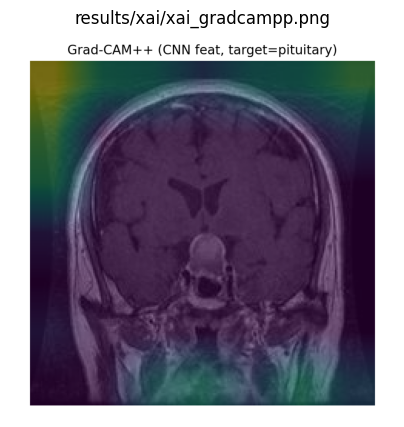

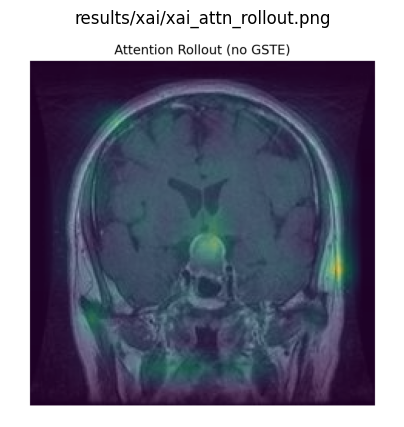

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

for p in ["results/xai/xai_gradcampp.png", "results/xai/xai_attn_rollout.png"]:
    img = Image.open(p)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(p)
    plt.axis("off")
    plt.show()

